# グラフ分割問題

ここでは、JijSolverとJijModelingを用いて、グラフ分割問題を解く方法を説明します。
この問題は、[Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full) 2.2. Graph Partitioningでも触れられています。

<!-- # Graph Partitioning

Here we show how to solve the graph partitioning problem using JijSolver and JijModeling. 
This problem is also mentioned in 2.2. Graph Partitioning on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full). -->

## グラフ分割問題とは

グラフ分割問題は、グラフを2つの頂点数が等しい部分グラフに分割するとき、それらの部分グラフ間を結ぶ辺の数を最小にすることを考える問題です。

<!-- ## What is Graph Partitioning?

Graph partitioning is the problem of dividing a graph into two subsets of equal size with the aim of minimizing the number of edges between the subsets.
 -->

### 例

次のような問題を考えましょう。
1~6の番号を持つ6つの頂点グラフにおいて

- 1は2, 3につながる
- 2は1, 3, 4につながる
- 3は1, 2につながる
- 4は2, 5, 6につながる
- 5は4, 6につながる
- 6は4, 5につながる

辺を持つとします。
それらの辺の数の差が最小となるように、3つの頂点をもつ2つの部分グラフに分割することを考えましょう。
この場合、最適解は$\{1, 2, 3\}, \{4, 5, 6\}$のようになり、2つの部分グラフが(2, 4)の1つの辺だけで結ばれているようなものとなります。

![](./assets/11-graph_partitioning_1.png)

<!-- ### Example

Let us take a look at the following situation.
Consider a graph with 6 vertices labeled from 1 to 6, and edges connecting the vertices as follows:
- 1 is connected to 2 and 3
- 2 is connected to 1, 3, and 4
- 3 is connected to 1 and 2
- 4 is connected to 2, 5, and 6
- 5 is connected to 4 and 6
- 6 is connected to 4 and 5

The goal is to partition this graph into two subsets of equal size (i.e., 3 vertices in each subset) with minimized edges between them.
In this case, the optimal solution is $\{1, 2, 3\}, \{4, 5, 6\}$, where there is only 1 edge connecting vertices in different subsets (i.e., the edge (2,4)), which is the minimum possible number of edges connecting the two subsets. 

![](./assets/11-graph_partitioning_1.png) -->

### 数理モデル

無向グラフを$G = (V, E)$としましょう。
ここで$V$はグラフ頂点の集合、$E$はグラフの辺の集合を表します。
このグラフを$V_1, V_2$に分割するとき、それらの部分グラフの間を結ぶ辺の数を最小にするのが目標です。
そこで、頂点$u$が部分グラフ$V_1$に属するとき1, $V_2$に属するとき0となるようなバイナリ変数$x_u$を導入します。

<!-- ### Mathematical Model

Let $G=(V, E)$ be the undirected graph where $V$ is the set of vertices and $E$ is the set of edges.
The goal is to partition $V$ into two subsets $V_1$ and $V_2$ of equal size, with the number of edges crossing the partition being minimized.
We introduce variables $x_{u}$ which is 1 if vertex $u$ is in the subset $V_1$ and 0 if vertex $u$ is in the subset $V_2$.
 -->

**制約: 頂点集合は、等しい頂点数の2つの部分グラフに分割しなければならない**

これは、次のような数式で表現されます。

$$
\sum_{u \in V} x_u = \frac{V}{2} \tag{1}
$$

<!-- **Constraint: the vertices must be partitioned into two equal-sized sets**

We express this constraint as follows:

$$
∑_{u \in V} x_u = V/2 \tag{1}
$$
 -->

**目的関数: 分割されたグラフ間の辺の数を最小化する**

$$
\min \quad 
\sum_{(uv) \in E} (\{x_{u} (1-x_{v})\}+\{(1-x_{u}) x_{v}\})
 \tag{2}
$$

第一項の$x_u (1-x_v)$は、辺$(u, v)$が$V_1$と$V_2$の境界にある場合 (例えば$u$は$V_1$に属し$v$は$V_2$に属する場合)のみ1となり、それ以外の場合には0となります。
同様に、第二項の$(1-x_u) x_v$は、辺$(u, v)$が$V_2$と$V_1$の境界にある場合 (例えば$u$は$V_2$に属し$v$は$V_1$に属する場合)のみ1となり、それ以外の場合には0となります。したがってこの目的関数が、グラフ分割がどれだけ達成されたかの指標となることがわかります。

<!-- **Objective function: minimize the number of edges crossing the partition**

$$
\min \quad 
\sum_{(uv) \in E} (\{x_{u} (1-x_{v})\}+\{(1-x_{u}) x_{v}\})
 \tag{2}
$$

Here, the first term $x_u (1 - x_v)$ evaluates to 1 if edge (u, v) crosses the boundary between $V_1$ and $V_2$ (i.e., if $u$ belongs to $V_2$ and $v$ belongs to $V_1$), and 0 otherwise. Similarly, the second term $(1 - x_u) x_v$ evaluates to 1 if edge (u, v) crosses the boundary between $V_1$ and $V_2$ (i.e., if $u$ belongs to $V_1$ and $v$ belongs to $V_2$), and 0 otherwise.

Thus, this objective function is an indicator of how much graph partitioning has been achieved. -->

## JijModelingによるモデル化

次に、JijModelingを用いた実装を示します。最初に、上述の数理モデルで用いる変数を定義しましょう。

<!-- ## Modeling by JijModeling

Next, we show an implementation using JijModeling. We first define variables for the mathematical model described above. -->

In [3]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', ndim=2)
x = jm.BinaryVar('x', shape=(V,))
u = jm.Element('u', belong_to=V)
e = jm.Element('e', belong_to=E)

`V=jm.Placeholder("V")`はグラフの頂点数を表します。
`E=jm.Placeholder("E", ndim=2)`はグラフの辺集合を意味します。
そして`x=jm.BinaryVar("x", shape=(V, ))`でバイナリ変数のリストを準備し、数理モデルで用いる添字を`u`として定義しています。
最後に、`e`は辺を表す変数であり、`e[0], e[1]`は辺で結ばれる2つの頂点を表しています。

<!-- `V=jm.Placeholder('V')` represents the number of vertices. 
We denote `E=jm.Placeholder('E', ndim=2)` as a set of edges.
Then, we define a list of binary variables `x=jm.BinaryVar('x', shape=(V,))`, and we set the subscripts `u` used in the mathematical model.
Finally, `e` represents the variable for edges. `e[0]` and `e[1]` represent the two vertices connected by the edge. -->

### 制約

式(1)の制約を実装しましょう。

<!-- ### Constraint

We implement a constraint Equation (1). -->

In [4]:
# set problem
problem = jm.Problem('Graph Partitioning')
# set constraint: the vertices must be partitioined into two equal-sized sets
const = jm.sum(u, x[u])
problem += jm.Constraint('constraint', const==V/2)

### 目的関数

次は、式(2)の目的関数の実装です。

<!-- ### Objective function

Next, we implement an objective function Equation (2). -->

In [5]:
# set objective function: minimize the number of edges crossing the partition
A_1 = x[e[0]]*(1-x[e[1]])
A_2 = (1-x[e[0]])*x[e[1]]
problem += jm.sum(e, (A_1 + A_2))

実装した数理モデルを、Jupyter Notebook上で表示してみましょう。

<!-- Let's display the implemented mathematical model in Jupyter Notebook. -->

In [6]:
problem

## インスタンスの準備

[NetworkX](https://networkx.org/)を用いて、グラフを準備しましょう。
ここでは、12個の頂点をもつランダムグラフを生成してみます。

<!-- ## Prepare an instance

We prepare a graph using [NetworkX](https://networkx.org/). 
Here we create random graph with 12 vertices. -->

In [7]:
import networkx as nx

# set the number of vertices
inst_V = 12
# create a random graph
inst_G = nx.gnp_random_graph(inst_V, 0.4)
# get information of edges
inst_E = [list(edge) for edge in inst_G.edges]
instance_data = {'V': inst_V, 'E': inst_E}

## JijSolverで解く

`jijsolver`を用いて、この問題を解いてみましょう。

## Solve by JijSolver

We solve this problem using `jijsolver`.

In [8]:
import jijsolver

interpreter = jm.Interpreter(instance_data)
instance = interpreter.eval_problem(problem)
solution = jijsolver.solve(instance, time_limit_sec=1.0)

## 解の可視化

最後に、得られた解を可視化してみましょう。

<!-- ## Visualize the solution

In the end, we visualize the solution obtained. -->

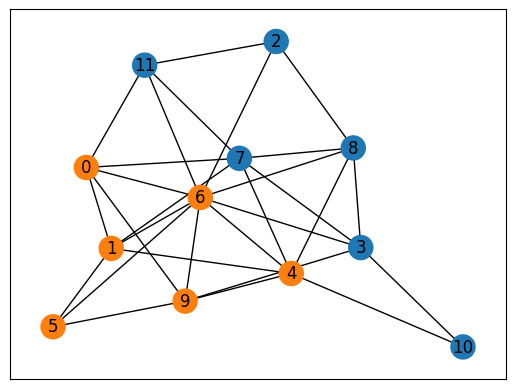

In [9]:
import matplotlib.pyplot as plt
import numpy as np

df = solution.decision_variables
x_indices = np.ravel(df[df["value"]==1]["subscripts"].to_list())
# set color list for visualization
cmap = plt.get_cmap("tab10")
# initialize vertex color list
node_colors = [cmap(0)] * instance_data["V"]
# set vertex color list
for i in x_indices:
    node_colors[i] = cmap(1)
# make figure
nx.draw_networkx(inst_G, node_color=node_colors, with_labels=True)
plt.show()

可視化結果から、このグラフ分割問題の実行可能解が得られていることがわかります。

<!-- With the above visualization, we obtain a feasible partitioning for this graph. -->